# Project 2: Prediction of Ames Housing Sale Price  
--- 
- [EDA and Cleaning](./1_EDA_and_Cleaning.ipynb) 
- [Preprocessing and Feature Engineering](./2_Preprocessing_and_Feature_Engineering.ipynb)
- [Model Benchmarks](./3_Model_Benchmarks.ipynb)
- [Model Tuning](./4_Model_Tuning.ipynb)
- <b>Production Model and Insights</b>

In [140]:
#Importing libraries 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV 
from sklearn.metrics import mean_squared_error, r2_score

--- 
## Overview 

In this notebook, I will calculate the r2 score and RMSE from the production model on the train set. I will then fit the same model on the test dataset to obtain the predicted sale prices, which will be used for the Kaggle submission. I will also state the insights gleaned from the model and subsequent business recommendations

--- 
## Contents 

- [Production model on train data](#Production-model-on-train-data)
- [Production model on test data](#Production-model-on-test-data)
- [Exporting submission to Kaggle competition](#Exporting-predicted-sale-price-for-submission-to-Kaggle-competition)
- [Insights and recommendations](#Insights-and-recommendations) 

---
## Production model on train data

In the previous notebook, I determined that the features matrix should consist of the 30 best performing features (in terms of coefficient values). Having modelled with 20, 30, 40, 50 of the features with highest coefficients, I found that the model with 30 features performed the best. 
- I used lasso regression to reduce the no of features from 193 to 101, before using ridge regression to further reduce to 30 features (see notebook 4_Model Tuning)
- I found that the production model performed the best when using features derived from this method of selection 

I will now run the production model with the chosen features and the with Ridge, Lasso and Elastic Net regression models on the train dataset, and choose the model with the best r2 scores for the train and test set, as well as the best RMSE
- Elastic Net is the best regression model
    - r2 score for train set is 0.909
    - r2 score for test set is 0.900 (enet model had least variance between train and test r2 scores)
    - RMSE is 25137 (lowest out of all 3 models)


In [141]:
#import train_dummies. csv as train and final_features.csv as final
#final_features.csv is a dataset consisting of all 30 features to be used in the production model 

train = pd.read_csv('../datasets/train_dummies.csv')
final = pd.read_csv('../datasets/final_features.csv')

In [142]:
train.head(2)

,id,lotfrontage,lotarea,lotshape,overallqual,overallcond,yearbuilt,masvnrarea,exterqual,bsmtqual,bsmtexposure,bsmtfinsf1,bsmtunfsf,heatingqc,grlivarea,bsmtfullbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,fireplaces,fireplacequ,garagearea,garagecond,wooddecksf,mosold,yrsold,saleprice,porch,pool,garage,fireplace,bsmt,masvnr,agesold,remodelled,bighouse,2ndflr,mssubclass_150,mssubclass_160,mssubclass_180,mssubclass_190,mssubclass_20,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90,mszoning_C (all),mszoning_FV,mszoning_I (all),mszoning_RH,mszoning_RL,mszoning_RM,landcontour_HLS,landcontour_Low,landcontour_Lvl,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_sloped,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_Membran,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkFace,masvnrtype_None,masvnrtype_Stone,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_None,bsmtfintype1_Rec,bsmtfintype1_Unf,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sal,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,garagefinish_None,garagefinish_RFn,garagefinish_Unf,paveddrive_P,paveddrive_Y
0,109,0.0,13517,1,6,8,1976,289.0,4,3,1,533.0,192.0,5,1479,0.0,2,1,3,1,4,0,0,475.0,3,0,3,2010,130500,1,0,1,0,1,1,34,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
1,544,43.0,11492,1,7,5,1996,132.0,4,4,1,637.0,276.0,5,2122,1.0,2,1,4,1,4,1,3,559.0,3,0,4,2009,220000,1,0,1,1,1,1,13,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1


In [143]:
final.head(2)

,grlivarea,bsmtfinsf1,overallqual,neighborhood_NridgHt,exterqual,garagearea,bsmtexposure,neighborhood_StoneBr,overallcond,masvnrarea,kitchenqual,bldgtype_TwnhsE,bsmtunfsf,bsmtfintype1_None,bsmtqual,bldgtype_Twnhs,exterior1st_BrkFace,functional_Typ,agesold,yearbuilt,neighborhood_GrnHill,garagefinish_RFn,mssubclass_20,roofmatl_WdShngl,masvnr,neighborhood_NoRidge,bedroomabvgr,masvnrtype_Stone,fireplaces,lotarea
0,1479,533.0,6,0,4,475.0,1,0,8,289.0,4,0,192.0,0,3,0,0,1,34,1976,0,1,0,0,1,0,3,0,0,13517
1,2122,637.0,7,0,4,559.0,1,0,5,132.0,4,0,276.0,0,4,0,0,1,13,1996,0,1,0,0,1,0,4,0,1,11492


In [144]:
#creating features matrix (X) and target vector(y)
X = train[final.columns]
y = train['saleprice']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#scale data 
ss=StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

#hyperparameter tuning for ridge, lasso, elastic net
ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=5)
ridge = ridge.fit(X_train, y_train)
ridge_optimal_alpha = ridge.alpha_
print (f" ridge optimal alpha is {ridge_optimal_alpha}")
print(' ')

lasso = LassoCV(alphas=np.linspace(.001, 1000, 200), cv=5)
lasso = lasso.fit(X_train, y_train)
lasso_optimal_alpha = lasso.alpha_
print (f" lasso optimal alpha is {lasso_optimal_alpha}")
print(' ')

enet = ElasticNetCV(alphas = np.arange(0.001, 1.0, 0.005), l1_ratio=0.5)
enet = enet.fit(X_train, y_train)
enet_optimal_alpha = enet.alpha_
print (f" enet optimal alpha is {enet_optimal_alpha}")
print(' ')

#instantiating elastic net model
ridge_opt = Ridge(alpha=ridge_optimal_alpha)
lasso_opt = Lasso(alpha=lasso_optimal_alpha)
enet_opt = ElasticNet(alpha=enet_optimal_alpha)

#fit model and deriving r2 scores for train, test and RMSE for test set
ridge_opt.fit(X_train, y_train)
print (f" ridge regression model: r2 score for train set is {ridge_opt.score(X_train, y_train)}")
print (f" ridge regression model: r2 score for test set is {ridge_opt.score(X_test, y_test)}")
ridge_pred = ridge_opt.predict(X_test)
ridge_rmse = (mean_squared_error(y_test, ridge_pred))**0.5
print (f" ridge regression model: RMSE is {ridge_rmse}")
print(' ')

lasso_opt.fit(X_train, y_train)
print (f" lasso regression model: r2 score for train set is {lasso_opt.score(X_train, y_train)}")
print (f" lasso regression model: r2 score for test set is {lasso_opt.score(X_test, y_test)}")
lasso_pred = lasso_opt.predict(X_test)
lasso_rmse = (mean_squared_error(y_test, ridge_pred))**0.5
print (f" lasso regression model: RMSE is {lasso_rmse}")
print(' ')

enet_opt.fit(X_train, y_train)
print (f" enet regression model: r2 score for train set is {enet_opt.score(X_train, y_train)}")
print (f" enet regression model: r2 score for test set is {enet_opt.score(X_test, y_test)}")
enet_pred = enet_opt.predict(X_test)
enet_rmse = (mean_squared_error(y_test, enet_pred))**0.5
print (f" enet regression model: RMSE is {enet_rmse}")

 ridge optimal alpha is 18.041864093920726
 
 lasso optimal alpha is 20.101482412060303
 
 enet optimal alpha is 0.031
 
 ridge regression model: r2 score for train set is 0.909915645125219
 ridge regression model: r2 score for test set is 0.9001596565806617
 ridge regression model: RMSE is 25155.90254935767
 
 lasso regression model: r2 score for train set is 0.9099832552446001
 lasso regression model: r2 score for test set is 0.8995128215310574
 lasso regression model: RMSE is 25155.90254935767
 
 enet regression model: r2 score for train set is 0.909869463350285
 enet regression model: r2 score for test set is 0.9003085137202673
 enet regression model: RMSE is 25137.142435065616


In [145]:
pred = enet_opt.predict(X_train)
pred.mean()

182006.86049543676

---
## Production model on test data

The production model will be used on the test data to see if the r2 score and RMSE is close to the scores from the train data

### Importing preprocessed test data

Test data has already been cleaned in the Preprocessing and Feature Engineering notebook

In [146]:
test = pd.read_csv('../datasets/test_preprocessed.csv')

In [147]:
test.head(2)

,id,mssubclass,mszoning,lotfrontage,lotarea,lotshape,landcontour,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,foundation,bsmtqual,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtunfsf,heatingqc,electrical,grlivarea,bsmtfullbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,functional,fireplaces,fireplacequ,garagetype,garagefinish,garagearea,garagecond,paveddrive,wooddecksf,mosold,yrsold,porch,pool,garage,fireplace,bsmt,masvnr,agesold,remodelled,bighouse,2ndflr
0,2658,190,RM,69.0,9142,0,Lvl,Inside,flat,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,Gable,CompShg,AsbShng,AsbShng,None,0.0,3,Stone,2,1,Unf,0,1020,4,FuseP,1928,0,2,0,4,2,2,Typ,0,0,Detchd,Unf,440,1,Y,0,4,2006,1,0,1,0,1,0,96,0,0,1
1,2718,90,RL,0.0,9662,1,Lvl,Inside,flat,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,Gable,CompShg,Plywood,Plywood,None,0.0,3,CBlock,4,1,Unf,0,1967,3,SBrkr,1967,0,2,0,6,2,3,Typ,0,0,Attchd,Fin,580,3,Y,170,8,2006,0,0,1,0,1,0,29,1,0,0


In [148]:
#convert mssubclass to str. it converted back to int when imported
test['mssubclass'] = test['mssubclass'].apply(str)

In [149]:
test.shape

(879, 60)

### One-hot encoding for test data

The one-hot encoding has produced 174 columns in the test dataset. 

One of the final features used for the production model is not present in the test_dummies data. As there are only 2 rows in the train dataset with 'neighborhood_GrnHill' = 1 (present), this feature can be removed as it is unlikely to significantly affect predictions of saleprice. This leaves 39 features in the features vector. 

In [150]:
test_dummies = pd.get_dummies(test, drop_first = True)

In [151]:
test_dummies.shape

(879, 184)

In [152]:
#checking for features which are present in train_dummies but not in test_dummies
[col for col in final if col not in test_dummies]

['neighborhood_GrnHill']

In [153]:
train['neighborhood_GrnHill'][train['neighborhood_GrnHill'] ==1].count()

2

In [154]:
#dropping neighborhood_GrnHill feature as it only has two rows indicating its presence (value=1)
final.drop(['neighborhood_GrnHill'], axis =1, inplace=True)

In [155]:
#adding 31st best performing feature, agesold, which is present in test_dummies 
#(this is derived from feature coefficients after running lasso regression model, see previous notebook)

final['landcontour_HLS'] = train['landcontour_HLS']

In [156]:
final.head()

,grlivarea,bsmtfinsf1,overallqual,neighborhood_NridgHt,exterqual,garagearea,bsmtexposure,neighborhood_StoneBr,overallcond,masvnrarea,kitchenqual,bldgtype_TwnhsE,bsmtunfsf,bsmtfintype1_None,bsmtqual,bldgtype_Twnhs,exterior1st_BrkFace,functional_Typ,agesold,yearbuilt,garagefinish_RFn,mssubclass_20,roofmatl_WdShngl,masvnr,neighborhood_NoRidge,bedroomabvgr,masvnrtype_Stone,fireplaces,lotarea,landcontour_HLS
0,1479,533.0,6,0,4,475.0,1,0,8,289.0,4,0,192.0,0,3,0,0,1,34,1976,1,0,0,1,0,3,0,0,13517,0
1,2122,637.0,7,0,4,559.0,1,0,5,132.0,4,0,276.0,0,4,0,0,1,13,1996,1,0,0,1,0,4,0,1,11492,0
2,1057,731.0,5,0,3,246.0,1,0,7,0.0,4,0,326.0,0,3,0,0,1,57,1953,0,1,0,0,0,3,0,0,7922,0
3,1444,0.0,5,0,3,400.0,1,0,5,0.0,3,0,384.0,0,4,0,0,1,4,2006,0,0,0,0,0,3,0,0,9802,0
4,1445,0.0,6,0,3,484.0,1,0,8,0.0,3,0,676.0,0,2,0,0,1,110,1900,0,0,0,0,0,3,0,0,14235,0


### Re-doing train-test-split as feature matrix has been changed

In [157]:
#creating features matrix (X) and target vector(y)
X = train[final.columns]
y = train['saleprice']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Creating features vector (X_test) for test data
Target vector remains 'saleprice', which is found in train dataset

In [158]:
X1 = test_dummies[final.columns]
y = train['saleprice']

In [159]:
X1.shape

(879, 30)

In [160]:
X_train.shape

(1534, 30)

### Scaling data

In [161]:
ss=StandardScaler()
ss.fit(X_train, y_train)
X_train = ss.transform(X_train)
X1 = ss.transform(X1)

### Fitting and predicting sale prices from test data

In [162]:
#hyperparameter tuning for elastic net
enet = ElasticNetCV(alphas = np.arange(0.00001, 1.0, 0.005), l1_ratio=0.5)
enet = enet.fit(X_train, y_train)
enet_optimal_alpha = enet.alpha_
print (f" enet optimal alpha is {enet_optimal_alpha}")

#instantiating elastic net model
enet_opt = ElasticNet(alpha=enet_optimal_alpha)

#fit model 
enet_opt.fit(X_train, y_train)

 enet optimal alpha is 0.03001


ElasticNet(alpha=0.03001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [163]:
test_predictions = enet_opt.predict(X1)

In [164]:
test_predictions.mean()

179993.44050162664

## Exporting predicted sale price for submission to Kaggle competition 

A submission.csv file consisting of 'Id' and 'SalePrice' will be created based on the sale price predictions from the test data. It will then be submitted to the Kaggle competition. 

**I got a private score of 29448 and a public score of 28415 with this submission**

In [165]:
submission = pd.DataFrame({'Id':test['id'], 'SalePrice':test_predictions})
submission.head()

,Id,SalePrice
0,2658,146097.781307
1,2718,164035.392700
2,2414,209462.939639
3,1989,114539.131759
4,625,170436.007936


In [166]:
submission.shape

(879, 2)

In [167]:
#exporting submission.csv
submission.to_csv('../datasets/submission.csv', index=False)

<img src="../images/kaggle.png" alt="Kaggle score"/>

---
## Insights and recommendations

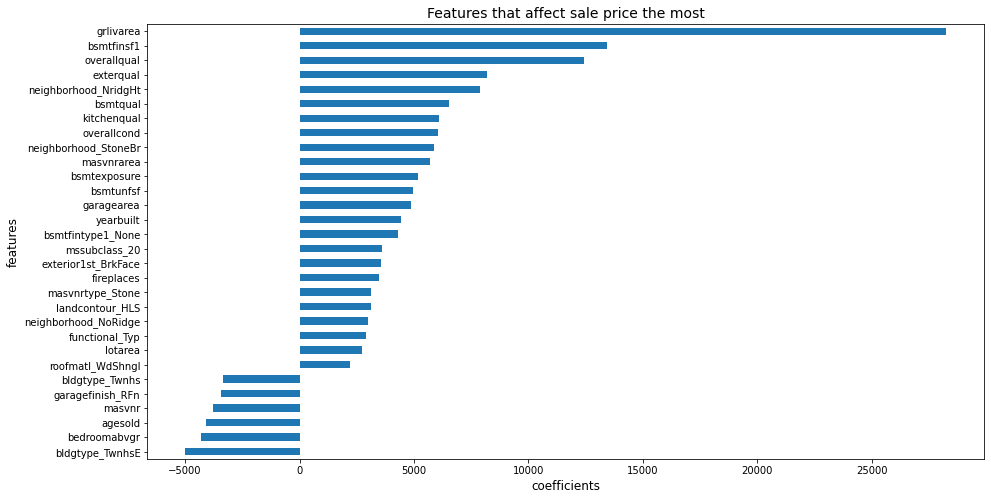

In [168]:
pd.Series(enet_opt.coef_, index=final.columns).sort_values(ascending=True).plot.barh(figsize=(15,8))
plt.title('Features that affect sale price the most', fontsize=14)
plt.xlabel('coefficients', fontsize=12)
plt.ylabel('features', fontsize=12);

| Feature   |      Positive coefficient value     |   Description |
|----------|:-------------:|------:|
| grlivarea   |      28268.17      |  Ground living area square feet | 
| bsmtfinsf1   |      13426.03      |  Finished square feet of basement| 
| overallqual   |      12409.69      |  Overall material and finish quality | 
| exterqual   |      8199.80      |  Exterior material quality | 
| neighborhood_NridgHt   |      7901.77      |  Neighborhood of Northridge Heights | 
| bsmtqual   |      6539.36      |  Height of the basement | 
| kitchenqual   |      6093.65      |  Kitchen quality | 
| overallcond   |      6054.61      |  Overall condition rating | 
| neighborhood_StoneBr   |      5893.02      |  Neighborhood of Stone Brook | 
| masvnrarea   |      5712.24      |  Masonry veneer area in square feet | 
| bsmtexposure   |      5188.69      | Exposure of walkout or garden level basement walls | 
| bsmtunfsf    |      4940.16      | Unfinished square feet of basement area | 
| garagearea    |     4887.56      |  Size of garage in square feet | 
| yearbuilt    |      4440.81      |  Original construction date | 
| bsmtfintype1_None    |      4301.95      |  No basement | 
| mssubclass20   |      3590.55      |  1-story, 1946 & newer, all styles of house | 
| exterior1st_BrkFace   |      3570.13      |  Exterior covering on house: Brick Face | 
| fireplaces   |      3457.36      |  Presence of fireplaces in house | 
| masvnrtype_Stone   |      3116.82      |  Masonry veneer type: Stone| 
| landcontourHLS   |      3108.71      |  Flatness of property: Hillside | 
| neighborhood_NoRidge   |      2994.66      |  Neighbourhood of Northridge | 
| functional_Typ   |      2896.49      |  Home functionality rating: Typical functionality (highest) | 
| lotarea   |      2726.78      |  Lot size in square feet | 
| roofmatl_WdShngl   |      2212.46      |  Roof material: Wood Shingles | 

| Feature   |      Negative coefficient value     |   Description |
|----------|:-------------:|------:|
| bldgtype_TwnhsE    |      -4984.04      |  Type of dwelling: Townhouse End Unit | 
| bedroomabvgr   |      -4285.02      |  Number of bedrooms above basement level | 
| agesold   |      -4076.55      |  Age of house when sold | 
| masvnr   |      -3791.38      |  Presence of Masonry veneer in house | 
| garagefinish_R_Fn   |      -3453.23      |  Interior finish of garage: Rough Finished | 
| bldgtype_TwnhsI   |      - 3340.63      |  Type of dwelling: Townhouse Inside Unit | 





### Insights on Ames housing dataset

The Elastic Net Regression model had the best predictive performance on the Ames housing dataset, outperforming the Linear, Ridge and Lasso Regression models. The tables above shows the top 30 features that affected the prediction of sale price. The coefficient value shows how significant the feature is in affecting sale price. 

A positive correlation value means that for a 1 unit increase in the feature, the sale price increases by the coefficient value. Conversely, a negative correlation value means that for a 1 unit increase in the feature, the sale price decreases by the correlation value

#### Features that have positive effect on sale price
As expected, the square footage of the house, basement, garage and the overall lot area has the most significant positive effect on the sale price, i.e., higher square footage means higher price. 

The data also shows that single storey houses generally command a higher price per square foot, compared to two-storey, split, duplex, multilevel homes. Research showed that up to 64% of US buyers, especially baby-boomers, preferred single-storey houses as it would allow them to 'age-in-place' in a house without stairs <sup>[[1]](http://eyeonhousing.org/2016/04/housing-preferences-across-generations-part-iii/)</sup>.

Quality and condition of key features such as external areas, basement and kitchen significantly affect the sale price. The home should be typically functional  and finished, ideally at a move-in state. Generally, the younger the home, the higher the sale price. Hillside homes also command a higher price, likely for the better view. 

The most desirable neighbourhoods appear to be:
- Northridge Heights
    - Located in the Gilbert School District and close to Ada Hayden Lake and recreation area, Somerset Village restaurants and shopping, and North Grand Mall
- Stone Brook
    - 5 minute drive to Iowa State University, preferred neighborhood for students and faculty staff
- Northridge 
    - Situated close to three public schools, Somerset Village restaurants and shopping and North Grand Mall

The data also showed that a good-to-have feature in the house is a fireplace (or even multiple fireplaces), as Iowa faces very cold winters<sup>[[2]](https://weatherspark.com/y/10339/Average-Weather-in-Ames-Iowa-United-States-Year-Round)</sup><sup>[[3]](https://khak.com/iowa-ranked-among-states-with-most-miserable-winters/)</sup>. A brick exterior on the house also increases sale price due to its multiple benefits, particularly its good insulation and temperature control properties <sup>[[4]](https://turnbullmasonry.com/7-advantages-brick-exterior-home/)</sup>. 

#### Features that have negative effect on sale price
On the other hand, homes which are Townhouse End Units or Townhouse Inside Units perform the worse in terms of sale price psf. This is possibly because its layout is not as appealing to homebuyers in Ames. A townhouse is situated in a row of attached houses, and a lot size of a townhouse is smaller than a typical house and has no front or back lawn.

It also appears that the number of bedrooms negatively affects sale price. That may not necessarily be true. Based on data collected on homes sold in Bellingham, Washington from January to June 2015, sales of 2- and 3-bedroom homes are the highest, and the number decreases for 4- and 5-bedroom homes <sup>[[5]](https://a1builders.ws/2015/06/whats-the-resale-value-of-a-bedroom/)</sup>. Thus, I conclude that sale prices are only negatively affected when number of bedrooms in the house is more than 3.

While having good quality features would bring up the sale price, the data also showed that having unfinished features such as roughly-finished garages would cause sale price to decrease.

Interestingly, the presence of masonry veneer has a significant negative effect on the sale price. 
- However, if the homeowner had installed stone masonry veneer over a significantly large area of the home, it had a positive effect on the price of the home. 

### Recommendations

#### Homeowners looking to increase the value of their property could carry out the following renovations
- Improving the quality and condition of key home features such as the external areas (i.e., lawn, porch, etc), basement and kitchen 
- Making sure the home is in a finished condition, ideally in a move-in state when selling 
- Installing features that would keep the house warm during freezing winters, such as fireplaces in the home and a brick exterior for better insulation

#### Considerations for buyers looking to purchase a house in Ames
- Ideal neighbourhoods to purchase homes in are Northridge Heights, Stone Brookes or Northridge, which would give better returns on property investments
- Homes with large square footage and in good, finished condition will command a higher price
- Single-storey homes have better sale price psf than other types of homes, while townhouses have the lowest value psf. 
- Homes with 2- or 3- bedrooms are ideal, any more bedrooms could decrease the home value
- Look for homes with fireplaces and brick exteriors which could increase the home value, while the presence of masonry veneer could decrease the home value
- Younger homes have higher value


### What would help the model generalize well for other cities?

As it is, this model would not generalize well for other cities. It is developed to give predictions based on housing data from Ames, Iowa. It would not generalize well in other cities due to the different features of the homes in different cities and the different demographic of home buyers and owners. 

The model could be revised to become more generalizable if features such as neighborhoods were removed. Other features from non-landed housing (i.e.,apartments) could also added, since the Ames housing data set seemed to feature only landed properties. 

Furthermore, in order to make a comparable model on another city based on this model, data from 2006 to 2010 would be required since the Ames housing dataset only has data from 2006 to 2010. 